In [1]:
import copy
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
def r2_score(y, y_pred, y_train=None):
    sse = 0; sst = 0
    if y_train is None:        
        y_mean = np.mean(y)
    else:
        y_mean = np.mean(y_train)
    for i in range(len(y)):
        sse += (y[i] - y_pred[i]) ** 2
        sst += (y[i] - y_mean) ** 2
    r2_score = 1 - (sse / sst)
    return r2_score

In [3]:
def normalize(X):
    max_ = np.max(X, axis=0)
    min_ = np.min(X, axis=0)
    X_norm = (X - min_) / (max_ - min_)
    return max_, min_, X_norm

In [4]:
def standardize(X):
    mean_ = np.mean(X, axis=0)
    std_ = np.std(X, axis=0)
    X_norm = (X - mean_) / std_
    return X_norm, mean_, std_

In [5]:
def q2_loo(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y, y_pred)
    return r2, y_pred

In [6]:
def qsar_param(y, y_pred, d_r2m=True):
    results = []
    _, _, y = normalize(y)
    _, _, y_pred = normalize(y_pred)
    y_mean = np.mean(y); y_pred_mean = np.mean(y_pred)
    # calculate r2
    num = 0; den_1 = 0; den_2 = 0
    for i in range(len(y)):
        num += (y[i] - y_mean) * (y_pred[i] - y_pred_mean)
        den_1 += (y_pred[i] - y_pred_mean) ** 2
        den_2 += (y[i] - y_mean) ** 2
    r2 = num ** 2 / (den_1 * den_2)
    results = {"r2": r2}
    # calculate k and k_dash
    n_data = len(y)
    dot_ = 0; y_pred2 = 0; y2 = 0
    for i in range(n_data):
        dot_ += (y[i] * y_pred[i])
        y_pred2 += y_pred[i] ** 2
        y2 += y[i] ** 2
    k = np.sum(dot_) / np.sum(y_pred2)
    k_dash = np.sum(dot_) / np.sum(y2)
    results["k"] = k
    results["k_dash"] = k_dash
    # calculate r2_0 and r2_0_dash
    num = 0; num_dash = 0; den = 0; den_dash = 0
    for i in range(n_data):
        num += (y[i] - (k * y_pred[i])) ** 2
        num_dash += (y_pred[i] - (k_dash * y[i])) ** 2
        den += (y[i] - y_mean) ** 2
        den_dash += (y_pred[i] - y_pred_mean) ** 2
    r2_0 = 1 - (num / den)
    r2_0_dash = 1 - (num_dash / den_dash)
    #results.append(r2_0)
    #results.append(r2_0_dash)
    r2r0 = (r2 - r2_0)/r2
    r2r0_dash = (r2 - r2_0_dash)/r2
    results["r2r0"] = r2r0
    results["r2r0_dash"] = r2r0_dash
    r0r0_dash = np.abs(r2_0 - r2_0_dash)
    results["r0r0_dash"] = r0r0_dash
    # calculate rm2 and rm2_dash
    rm2 = r2 * (1 - np.sqrt(r2 - r2_0))
    rm2_dash = r2 * (1 - np.sqrt(r2 - r2_0_dash))
    #results.append(rm2)
    #results.append(rm2_dash)
    # calculate rm2_bar and d_rm2
    rm2_bar = (rm2 + rm2_dash) / 2
    d_rm2 = np.abs(rm2 - rm2_dash)
    results["rm2_bar"] = rm2_bar
    results["d_rm2"] = d_rm2
    return results

In [7]:
def y_random(estimator, X, y, n=10):
    # non-random
    estimator.fit(X, y)
    y_pred = estimator.predict(X)    
    r2_nr = r2_score(y, y_pred)
    r_nr = np.sqrt(r2_nr)
    n_data = X.shape[0]
    # random
    r2_rand = []
    range_ = list(range(n_data))
    for i in range(n):
        new_range_ = copy.deepcopy(range_)
        np.random.shuffle(new_range_)
        y_new = []
        for i in new_range_:
            y_new.append(y[i])
        y_new = np.array(y_new)
        estimator.fit(X, y_new)
        y_pred = estimator.predict(X)
        r2_rand.append(r2_score(y_new, y_pred))
    r2_rand_avg = np.average(r2_rand)
    rp = r_nr * np.sqrt(r2_nr - r2_rand_avg)
    return rp

In [8]:
def leverage(XtX, X):
    levs = []
    for i in range(X.shape[0]):
        x = X[i,:]
        lev = x.dot(XtX).dot(x.T)
        levs.append(lev)
    return levs

In [80]:
def applicability_domain(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(r2_score(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(r2_score(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./v2-linear_AD.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()

In [81]:
# Load Data Train csv
train = pickle.load(open('Train_Test/train_bams.p','rb'))
test = pickle.load(open('Train_Test/test_bams.p','rb'))
train.shape, test.shape

((107, 1876), (27, 1876))

# SVR_RBF

In [59]:
# Load Pickle rbf
params = pickle.load(open("data_RBF/params_rbf_10.p", "rb"))

label = pickle.load(open("desc/desc10.pkl", "rb"))
x_train = train.loc[:,label].to_numpy()
x_test = test.loc[:,label].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax rbf
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'rbf', C = params['C'],
           gamma = params['gamma'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [60]:
train_rbf = q2_loo(model, sc_x_train, y_train)
train_rbf

(array([0.76731539]),
 [7.343677152347025,
  5.640048603037845,
  6.181186090466073,
  7.051972476526224,
  5.450322919005324,
  8.168021447888385,
  6.89144795547227,
  8.778571178037375,
  5.469268886041402,
  7.089138866913938,
  7.410525118395231,
  6.561494537349775,
  8.219892509173363,
  6.3804551624034245,
  7.978257768803534,
  5.666809202757842,
  7.21737949887984,
  6.082587518498821,
  5.890940138573753,
  8.503789567966626,
  7.888393242384313,
  8.513364391512045,
  7.262132378486734,
  6.8326733770692885,
  8.164960759290356,
  6.222513906498762,
  5.557861866931262,
  6.7094088883801,
  8.184557846407008,
  5.689074319596674,
  4.331791075386531,
  5.518657932666818,
  5.713408715675013,
  5.469394542697656,
  6.379550183069816,
  6.0587031194887855,
  6.526263745662071,
  7.289565794666472,
  6.568587065383721,
  5.846568285154806,
  5.561806864715694,
  5.388680350041076,
  7.80623166629082,
  5.768354144394647,
  5.939680210574378,
  5.6340493583606985,
  5.514397662

In [61]:
train_rbf_r2 = r2_score(y_train, train_rbf[1])
train_rbf_r2

array([0.76731539])

In [62]:
y_test.shape, len(model.predict(x_test))

((27, 1), 27)

In [63]:
test_pred = model.predict(sc_x_test)
test_pred

array([5.76103213, 5.53728859, 5.56881797, 6.22508554, 8.43848571,
       7.03475966, 7.90860554, 5.76331892, 6.86089258, 5.73644217,
       5.62371234, 8.23068631, 8.57367611, 6.95750598, 5.84488571,
       5.51886324, 8.87361443, 5.66357674, 6.45670905, 7.17741268,
       6.40903392, 7.9816622 , 7.16517555, 6.61240168, 8.17589869,
       8.24551434, 5.57905115])

In [64]:
rbf_qsar = qsar_param(y_train, train_rbf[1], d_r2m=True)
pd.DataFrame(rbf_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.77069,0.823326,1.111236,0.061217,0.416093,0.273499,0.468775,0.26903


In [65]:
rbf_qsar = qsar_param(y_test, test_pred, d_r2m=True)
pd.DataFrame(rbf_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.848534,1.124548,0.826468,0.097496,0.0189,0.066691,0.672775,0.136603


In [66]:
rbf_y = y_random(model, sc_x_train, y_train, n=10)
rbf_y

array([0.7858796])

0.308411214953271


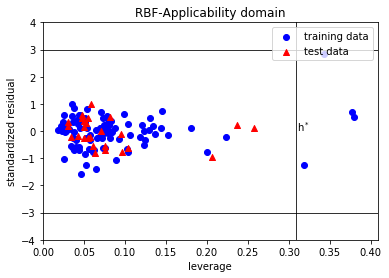

In [67]:
plt.title('RBF-Applicability domain')
rbf_AD = applicability_domain(sc_x_train, sc_x_test, y_train, train_rbf[1], y_test, test_pred)
rbf_AD

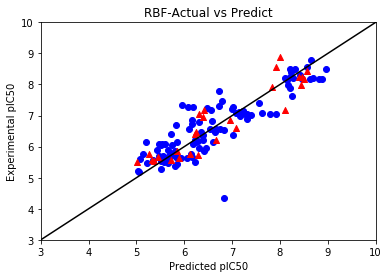

In [24]:
fig, ax = plt.subplots()
ax.scatter(y_train, train_rbf[1], c='b',marker='o', label='training data')
ax.scatter(y_test, test_pred, c='r',marker='^', label='test data')
ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
plt.title('RBF-Actual vs Predict')
plt.xlim(3,10)
plt.ylim(3,10)
ax.set_xlabel('Predicted pIC50')
ax.set_ylabel('Experimental pIC50')
plt.savefig('./rbf_Actual vs Predict.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

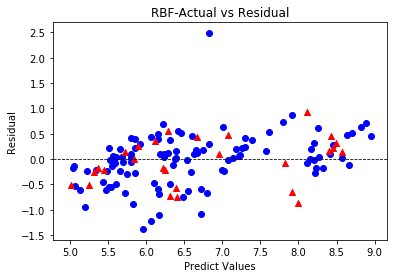

In [36]:
#dataframe to list
r_train = pd.DataFrame(y_train).to_numpy()
r_train_pred = pd.DataFrame(train_rbf[1]).to_numpy()
r_test = pd.DataFrame(y_test).to_numpy()
r_test_pred = pd.DataFrame(test_pred).to_numpy()

train = r_train-r_train_pred
test = r_test-r_test_pred
plt.axhline(y=0, c='k', linewidth=0.8, linestyle='--')
plt.scatter(r_train, train, c='b',marker='o', label='training data')
plt.scatter(r_test, test, c='r',marker='^', label='test data')
plt.title("RBF-Actual vs Residual")
plt.xlabel("Predict Values")
plt.ylabel("Residual")
plt.savefig('./rbf_Actual vs Residual.png', format='png', dpi=1000, bbox_inches="tight")

# SVR_Poly

In [72]:
# Load Pickle poly
params = pickle.load(open("data_Poly/params_poly_10.p", "rb"))

poly = pickle.load(open("desc/desc10.pkl", "rb"))
x_train = train.loc[:,poly].to_numpy()
x_test = test.loc[:,poly].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax poly
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'poly', C = params['C'],
           degree = params['degree'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)


SVR(C=1, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [73]:
train_q2_poly = q2_loo(model, sc_x_train, y_train)
train_q2_poly

(array([0.56756704]),
 [7.325880050912455,
  5.779464615440679,
  6.346790852031727,
  7.010483196944323,
  5.647791725586215,
  7.142783986820669,
  6.6189424535392,
  8.4734134060312,
  5.669330524446697,
  6.982790087532175,
  7.1013826787230965,
  6.581168966844398,
  7.1245065411752355,
  6.081755261090656,
  7.464203526753231,
  5.549641115808132,
  7.449429582943647,
  6.360058788001786,
  5.840155148307092,
  9.384360085451755,
  7.500581580117928,
  8.713488623801467,
  7.23534593881192,
  6.998524662277223,
  8.424890261819183,
  6.296174704749809,
  5.749356855430571,
  6.4414542333725935,
  8.150511723377395,
  5.589239316886034,
  2.740285952580652,
  5.62853407101081,
  6.138023428301112,
  5.705918437291625,
  6.13831655672835,
  6.382098973454646,
  6.390493427982529,
  6.639205993612643,
  6.4282292126070555,
  5.760661252911765,
  5.5457013519629115,
  5.428062111766569,
  7.712905924214326,
  6.094186706748419,
  6.1911809139281555,
  6.025190778415018,
  6.008508056

In [74]:
poly = r2_score(y_train, train_q2_poly[1])
poly

array([0.56756704])

In [75]:
poly_test_pred = model.predict(sc_x_test)
poly_test_pred

array([5.77444406, 5.54995789, 5.57554693, 6.20330858, 9.4883697 ,
       6.75358467, 8.71325867, 5.76467868, 6.79257895, 5.57409754,
       5.70243685, 7.40835586, 8.20730729, 6.71929485, 6.24516612,
       5.97995105, 8.74582095, 5.69241668, 6.744702  , 7.13125848,
       6.36997859, 7.33017921, 7.03491248, 6.8705054 , 7.12051971,
       8.02520372, 5.57327256])

In [76]:
poly_qsar = qsar_param(y_train, train_q2_poly[1], d_r2m=True)
pd.DataFrame(poly_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.58145,0.738768,1.115208,0.264387,4.859243,2.67168,-0.021216,0.749381


In [77]:
poly_qsar = qsar_param(y_test, poly_test_pred, d_r2m=True)
pd.DataFrame(poly_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.703911,1.328065,0.654766,0.194036,0.007502,0.131303,0.548261,0.208993


In [78]:
poly_y = y_random(model, sc_x_train, y_train, n=10)
poly_y

array([0.64328687])

0.308411214953271


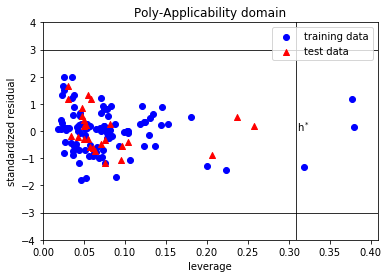

In [79]:
plt.title('Poly-Applicability domain')
poly_AD = applicability_domain(sc_x_train, sc_x_test, y_train, train_q2_poly[1], y_test, poly_test_pred)
poly_AD

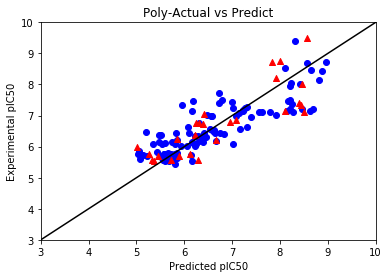

In [36]:
fig, ax = plt.subplots()
ax.scatter(y_train, train_q2_poly[1], c='b',marker='o', label='training data')
ax.scatter(y_test, poly_test_pred, c='r',marker='^', label='test data')
ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
plt.title('Poly-Actual vs Predict')
plt.xlim(3,10)
plt.ylim(3,10)
ax.set_xlabel('Predicted pIC50')
ax.set_ylabel('Experimental pIC50')
plt.savefig('./poly_Actual vs Predict.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

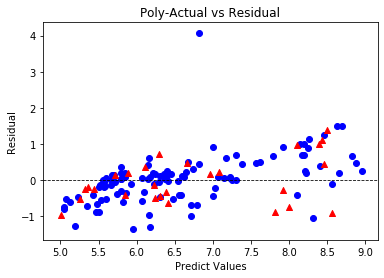

In [37]:
#dataframe to list
r_train = pd.DataFrame(y_train).to_numpy()
r_train_pred = pd.DataFrame(train_q2_poly[1]).to_numpy()
r_test = pd.DataFrame(y_test).to_numpy()
r_test_pred = pd.DataFrame(poly_test_pred).to_numpy()

p_train = r_train-r_train_pred
p_test = r_test-r_test_pred

plt.axhline(y=0, c='k', linewidth=0.8, linestyle='--')
plt.scatter(r_train, p_train, c='b',marker='o', label='training data')
plt.scatter(r_test, p_test, c='r',marker='^', label='test data')
plt.title("Poly-Actual vs Residual")
plt.xlabel("Predict Values")
plt.ylabel("Residual")
plt.savefig('./poly_Actual vs Residual.png', format='png', dpi=1000, bbox_inches="tight")

# SVR_Linear

In [82]:
# Load Pickle linear
params = pickle.load(open("data_Linear/params_linear_10.p", "rb"))

linear = pickle.load(open("desc/desc10.pkl", "rb"))
x_train = train.loc[:,linear].to_numpy()
x_test = test.loc[:,linear].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax linear
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'linear', C = params['C'],
           degree = params['degree'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)


SVR(C=1, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [83]:
train_q2_linear = q2_loo(model, sc_x_train, y_train)
train_q2_linear

(array([0.61807354]),
 [7.255032273567595,
  5.746805923367235,
  6.4317046179992605,
  7.0803687819080485,
  5.7979878037442445,
  7.1343949858777815,
  6.63886450029487,
  8.130741348332272,
  5.840654487906825,
  7.074286938157666,
  7.059005215412716,
  6.552256179646117,
  7.145611331099173,
  6.1009954787395735,
  7.481562447238422,
  5.381322929539687,
  7.385077411773606,
  6.418179668617437,
  6.041612825573445,
  8.761377142333384,
  7.546990662889742,
  7.589089758467094,
  7.143724686019743,
  7.0136249758900995,
  8.626654225260515,
  6.311657914616825,
  5.840445605944408,
  6.431044289165808,
  7.985928532990458,
  5.786816866851767,
  3.86201337857688,
  5.6917486207282435,
  6.168203831756767,
  5.890355538008524,
  6.32817814700492,
  6.418473218760422,
  6.382303099600005,
  6.622548822580008,
  6.451852479888831,
  5.683119228618892,
  5.530628188097262,
  5.8739257869202,
  7.160850383814266,
  6.10246562284958,
  6.220333944412421,
  5.9661184495503505,
  6.072522

In [84]:
linear = r2_score(y_train, train_q2_linear[1])
linear

array([0.61807354])

In [85]:
linear_test_pred = model.predict(sc_x_test)
linear_test_pred

array([5.73289313, 5.58038285, 5.63982166, 6.19849636, 8.59310824,
       6.88669716, 8.1996084 , 5.63283298, 6.81093955, 5.45347684,
       5.71768761, 7.33778256, 7.93916795, 6.62221518, 6.29124731,
       5.95209697, 8.03880801, 5.77152849, 6.73732864, 7.16958474,
       6.39175989, 7.36561942, 7.1416495 , 6.81501322, 7.16627347,
       7.98316188, 5.53813101])

In [86]:
linear_qsar = qsar_param(y_train, train_q2_linear[1], d_r2m=True)
pd.DataFrame(linear_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.619365,0.865612,0.984851,0.159272,2.171055,1.246028,0.162991,0.523685


In [87]:
linear_qsar = qsar_param(y_test, linear_test_pred, d_r2m=True)
pd.DataFrame(linear_qsar)

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.75024,1.150304,0.792608,0.057353,0.000514,0.042643,0.665059,0.140888


In [88]:
linear_y = y_random(model, sc_x_train, y_train, n=10)
linear_y

array([0.67263136])

0.308411214953271


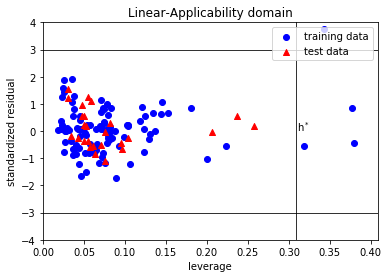

In [89]:
plt.title('Linear-Applicability domain')
linear_AD = applicability_domain(sc_x_train, sc_x_test, y_train, train_q2_linear[1], y_test, linear_test_pred)
linear_AD

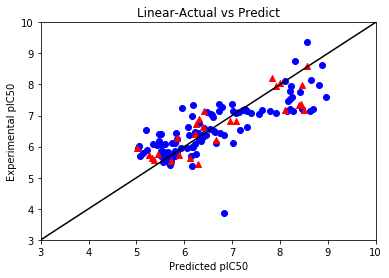

In [48]:
fig, ax = plt.subplots()
ax.scatter(y_train, train_q2_linear[1], c='b',marker='o', label='training data')
ax.scatter(y_test, linear_test_pred, c='r',marker='^', label='test data')
ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
plt.title('Linear-Actual vs Predict')
plt.xlim(3,10)
plt.ylim(3,10)
ax.set_xlabel('Predicted pIC50')
ax.set_ylabel('Experimental pIC50')
plt.savefig('./linear_Actual vs Predict.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

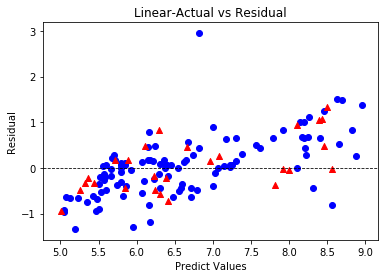

In [49]:
#dataframe to list
r_train = pd.DataFrame(y_train).to_numpy()
r_train_pred = pd.DataFrame(train_q2_linear[1]).to_numpy()
r_test = pd.DataFrame(y_test).to_numpy()
r_test_pred = pd.DataFrame(linear_test_pred).to_numpy()

l_train = r_train-r_train_pred
l_test = r_test-r_test_pred

plt.axhline(y=0, c='k', linewidth=0.8, linestyle='--')
plt.scatter(r_train, l_train, c='b',marker='o', label='training data')
plt.scatter(r_test, l_test, c='r',marker='^', label='test data')
plt.title("Linear-Actual vs Residual")
plt.xlabel("Predict Values")
plt.ylabel("Residual")
plt.savefig('./linear_Actual vs Residual.png', format='png', dpi=1000, bbox_inches="tight")